# physical validation of accelerometer-based state and wind estimation

MIT License

Copyright (c) 2022 Sawyer B. Fuller and Yash P. Talwekar

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
from numpy import array, sin, cos
import control as ct 

# 1. measure wind directly using accelerometer (no state estimation) 

In [2]:
def plot_actual_vs_predicted(datafile, start, dir='x', length=4):
    data = np.loadtxt(datafile, delimiter=',')
    # Reset timestamps to start from zero
    data[:, 0] = data[:, 0] - data[0, 0]
    # Actual measurements are in G's, convert to m/s^2
    data[:, [4, 5, 6]] = 9.81*data[:, [4, 5, 6]]

    time = data[:-1,0]/1000 - start - 0.5
    dt = np.diff(data[:,0]/1000)
    mask = (time > -0.5) & (time < length)
    
    b = 13.2e-3 # [Nm/s] for x and y
    # from System Identification of the Crazyflie 2.0 Nano Quadrocopter by raff d'andrea's group
    m = 30e-3 # [kg]

    if dir == 'x':
        v = np.diff(data[:,1])/dt
        v_predicted = -m / b * data[:-1,4] 
    elif dir == 'y':
        v = np.diff(data[:,2])/dt
        v_predicted = -m / b * data[:-1,5]
    
    plt.plot(time[mask], v[mask], 'k')#, label='true')

    plt.plot(time[mask], v_predicted[mask], 'grey')#, label='accelerometer estimate')
    plt.gca().axhline(lw=0.75, ls='--', c='k')   
    print(np.std(v_predicted[mask][1:40]))

0.4052384526364896
0.12695062726556966
0.2843445812576674


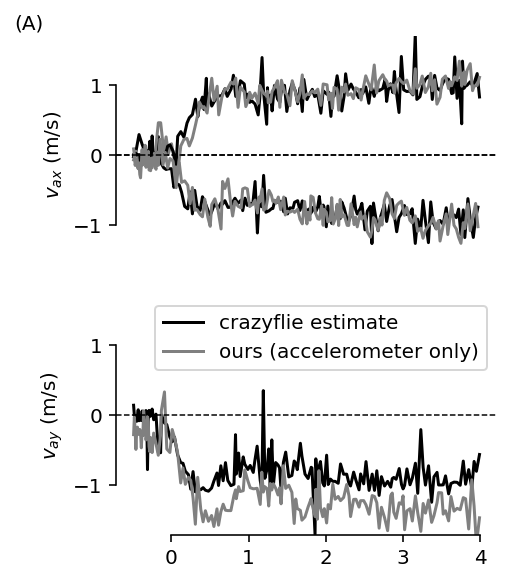

In [3]:
plt.figure(figsize=(3.5,4))
plt.subplot(211)
plot_actual_vs_predicted('meb_6.csv', 20.7)
plot_actual_vs_predicted('meb_2.csv', 6.5)
#plt.legend(('true','accelerometer estimate'))
plt.ylabel(r'$v_{ax}$ (m/s)')
plt.subplot(212)
#plot_actual_vs_predicted('crazyflie_data/meb_9.csv', 8, dir='y')
plot_actual_vs_predicted('meb_4.csv', 7.5, dir='y')
#plot_actual_vs_predicted('meb_9.csv', 18.5, dir='y')
#plot_actual_vs_predicted('crazyflie_data/meb_9.csv', 41, dir='y')
plt.ylabel(r'$v_{ay}$ (m/s)')
plt.legend(('crazyflie estimate','ours (accelerometer only)'), )

# cosmetic figure improvements
plt.subplot(211)
ax = plt.gca()
plt.ylim(-1.7,1.7)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_bounds((-1, 1))
ax.tick_params(bottom=False, labelbottom=False)
ax.spines.bottom.set_visible(False)
plt.subplot(212)
ax = plt.gca()
plt.ylim(-1.7,1.7)
ax.spines.left.set_bounds((-1, 1))
ax.spines.bottom.set_bounds(0, 4)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position('left')
plt.gcf().text(0,1, '(A)', verticalalignment='top') 
plt.tight_layout()
plt.savefig('accel_vs_estimator.pdf')

## calculate noise on ground and in air


x_rms_noise_onground = 0.01125489809827485
y_rms_noise_onground = 0.0116698086124964
x_rms_noise_inflight = 0.07776704659500065
y_rms_noise_inflight = 0.10663764897244526


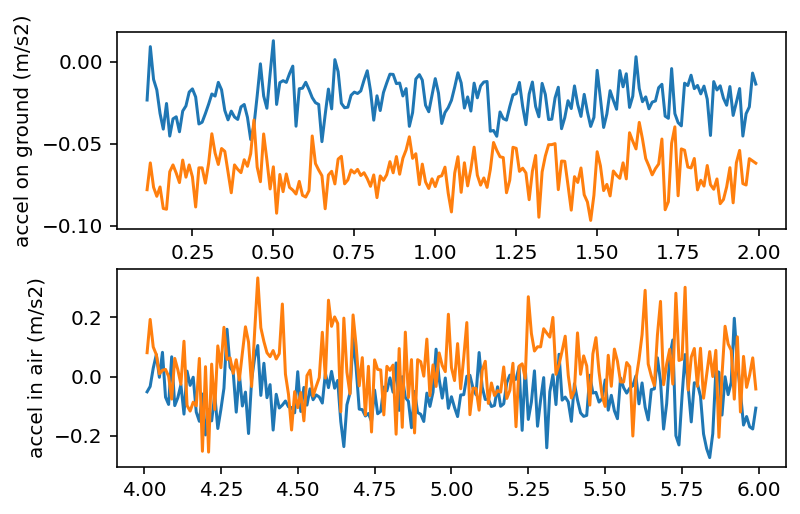

In [4]:
data = np.loadtxt('meb_1.csv',delimiter=',')
time = (data[:, 0] - data[0, 0])/1000 
# Actual measurements are in G's, convert to m/s^2
data[:, [4, 5, 6]] = 9.81*data[:, [4, 5, 6]]
mask_onground = (time > .1) & (time < 2)
mask_inflight = (time > 4) & (time < 6)
plt.subplot(211)
plt.plot(time[mask_onground], data[mask_onground, 4],time[mask_onground], data[mask_onground, 5])
plt.ylabel('accel on ground (m/s2)')
plt.subplot(212)
plt.plot(time[mask_inflight], data[mask_inflight, 4], time[mask_inflight], data[mask_inflight, 5])
plt.ylabel('accel in air (m/s2)')

# data rate is 100 hz. 
print('x_rms_noise_onground =',np.std(data[mask_onground, 4]))
print('y_rms_noise_onground =',np.std(data[mask_onground, 5]))
print('x_rms_noise_inflight =',np.std(data[mask_inflight, 4]))
print('y_rms_noise_inflight =',np.std(data[mask_inflight, 5]))



# 2. use full kalman filter estimator to estimate wind velocity and attitude

In [5]:
# crazyflie parameters
class p: pass # parameters bunch
p.h = 0.01 # height of body [m]
p.l = 0.06 # length of body [m]
p.J = 1.7e-5 # estimate [kgm^2] http://mikehamer.info/assets/papers/Crazyflie%20Modelling.pdf 
p.m = 30e-3 #mass [kg]
p.g = 9.81 # [ms^-2]
p.b = 2 * 6.6e-3 # air drag [Nsm^-1]
p.bz = 2e-3 # air drag [Nsm^-1]
p.d_z = 5e-3 # distance from center of mass to center of pressure along z-axis
p.zd = 1 # desired altitude [m]
#p.sensor_noise_std = array((.6, .1)) # [x-wind, optic flow]
p.sensor_noise_std = array((.3, .3, 3)) # [x-wind, z-wind, optic flow]

In [6]:
# KF design notes: 
# states to estimate: 
#           theta,    omega,       vx,       vz,    vwx
A_r = array([[  0,        1,        0,        0,      0], # theta
             [  0,        0,        0,        0,      0], # omega
             [p.g,        0, -p.b/p.m,        0,p.b/p.m], # vx
             [  0,        0,        0, -p.b/p.m,      0], # vz
             [  0,        0,        0,        0,      0]]) # vwx
# disturbance inputs
# d =       f_x,    f_z, tau_y, vwd (wind speed variability)
G_r = array([[0,      0,     0,   0], # theta 
             [0,      0, 1/p.J,   0], # omega
             [1/p.m,  0,     0,   0], # vx
             [0,  1/p.m,     0,   0], # vz
             [0,      0,     0,   1]]) # vwx
# measurements: vax_m, vaz_m, of_m
#         theta,    omega,       vx,      vz, vwx
C_r = array([[0,     0,          -1,       0,   1],  # vax_m
             [0,     0,           0,      -1,   0],  # vaz_m
             [0,     1,     -1/p.zd,       0,   0]]) # of_m
B_r = np.zeros((A_r.shape[0], 2))

# check observability
print("full obsv matrix rank =", np.linalg.matrix_rank(ct.obsv(A_r, C_r)), 
      "; A rank =", A_r.shape[0]) 

# process noise is your tuning knob. increase it to rely more on sensors
QN = np.diag(array([p.m/10, p.m/10, p.J/10, 6])**2) # [fx, fz, tauy, vwd]
RN = np.diag((p.sensor_noise_std)**2) # sensor noise
L = ct.lqe(A_r, G_r, C_r, QN, RN)[0]
print(f'{L=}')

full obsv matrix rank = 5 ; A rank = 5
L=array([[-4.26288836e-01,  5.80356963e-15, -8.09271474e-02],
       [-1.98388093e-01,  2.04122297e-15, -2.67868019e-02],
       [-3.70043611e+00,  1.62432262e-13, -1.22534904e+00],
       [-3.11588453e-16, -1.12006441e-01,  1.60391039e-15],
       [ 1.60720812e+01,  1.62743850e-13, -1.19032856e+00]])


In [7]:
def load_flight_data(datafile, tstart, tlength, p=p):
    data = np.loadtxt(datafile, delimiter=',')
    # time (ms), pitch (deg), vx (mm/s), z (mm), ax (m/s^2), az (m/s^2), gyro_y (deg/s), of_x, tof (mm)
    time, theta, vx, z, ax, az, gyro, of, tof = data.T
    
    time = time / 1000 - tstart
    mask = (time >= 0) & (time < tlength)
    return (
        time[mask], # [s] 
        np.deg2rad(theta[mask]), # [rad]
        vx[mask] / 1000, # [m/s]
        z[mask] / 1000, # [m]
        np.hstack((0, np.diff(z[mask])/np.diff(time[mask])))/1000, # vz [m/s]
        ax[mask] * p.m / p.b , # va_x [m/s]
        -az[mask] * p.m / p.bz + p.m * 9.81 / p.bz, # va_z [m/s]
        -of[mask] / 4.0926, # [rad/s]
        np.deg2rad(gyro[mask])) # [rad/s]

Simulate Kalman Filter estimator

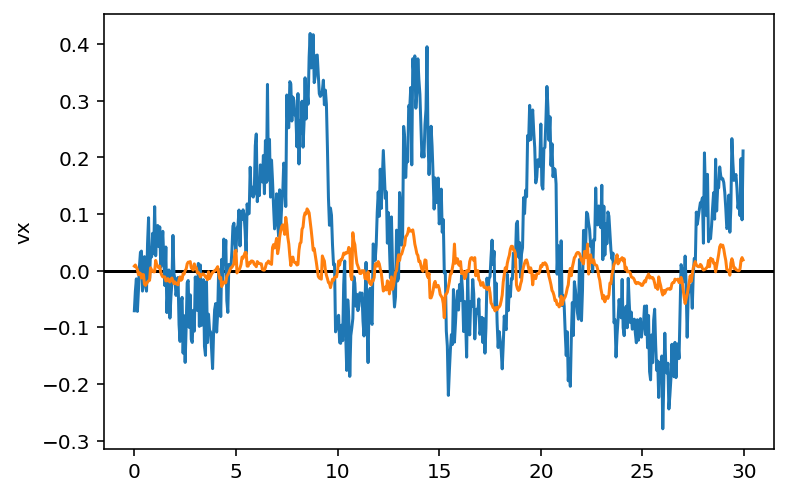

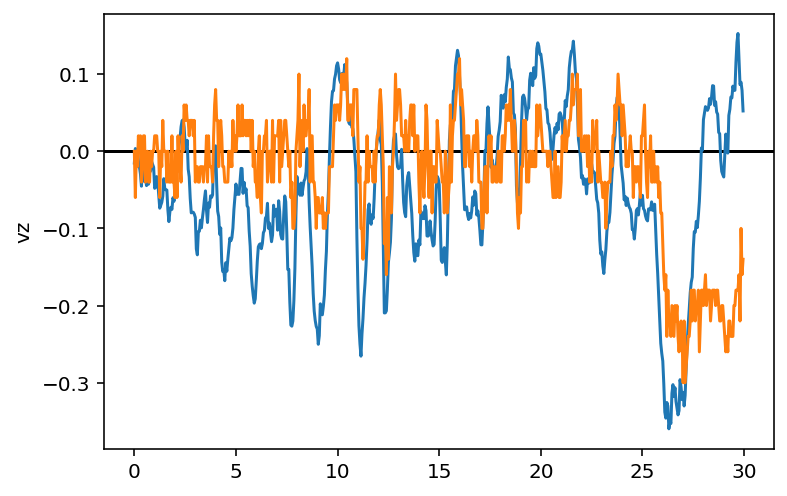

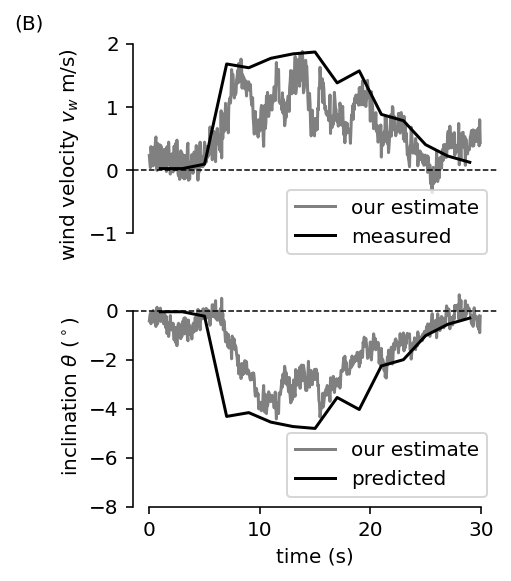

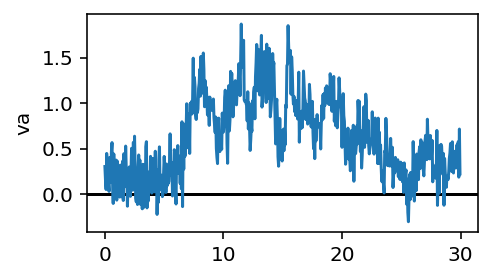

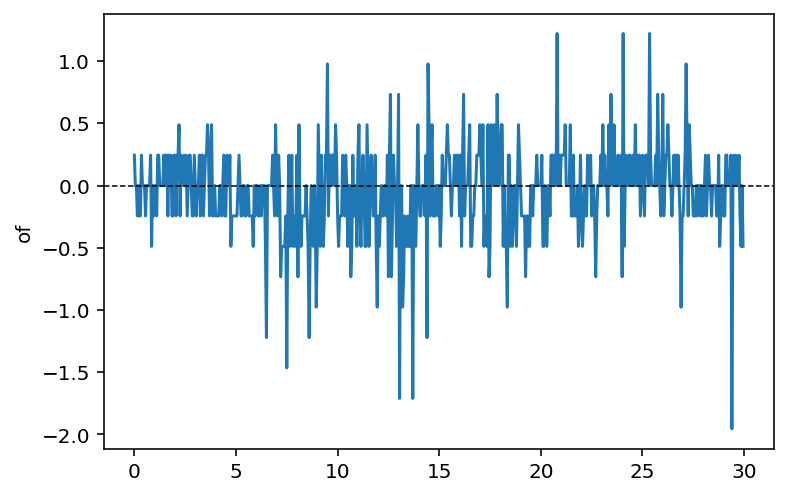

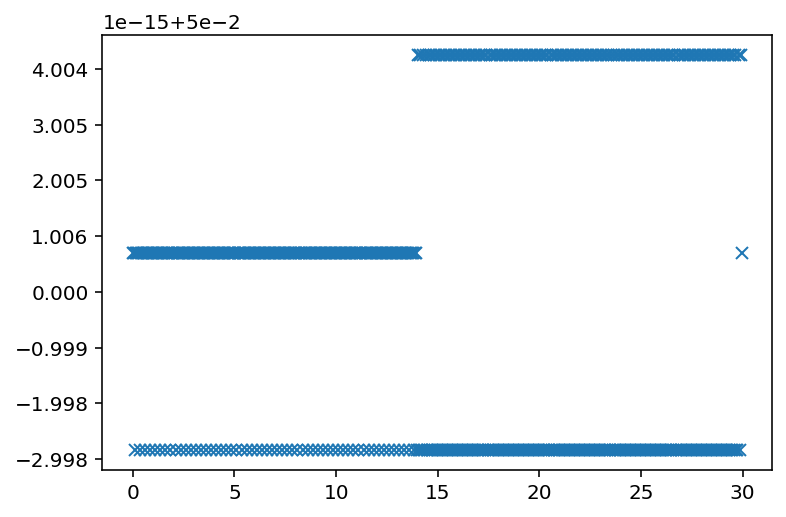

In [9]:
t_sim = 30
t_sim_start = 18
t_wind_start = 35
#       [thetay, omegay, vx, vz, vwx]
qhat = array([0,      0,  0, 0,    0]) # initial value of estimate
time_data, theta_data, vx_data, z_data, vz_data, vax_data, vaz_data, of_data, gyro_data = \
    load_flight_data('data2.csv', t_sim_start, t_sim)
dt_data = np.hstack((np.diff(time_data), time_data[1]-time_data[0]))

qhat_sim = np.zeros((len(time_data), len(qhat)))

# input sensor and output data from flight
y_data = np.vstack((vax_data, vaz_data, of_data)).T
u_data = np.zeros((len(time_data), 2)) # could incorporate this if had data from flight

# simulate
for idx, t in enumerate(time_data):
    qhatdot =  A_r @ qhat + B_r @ u_data[idx] + L @ (y_data[idx] - C_r @ qhat) # Kalman Filter estimate dynamics
    qhat = qhat + dt_data[idx] * qhatdot
    qhat_sim[idx] = qhat

theta_sim, omega_sim, vx_sim, vz_sim, vwx_sim = qhat_sim.T
plt.figure()
plt.gca().axhline(c='k')
plt.plot(time_data, vx_sim, time_data, vx_data)
plt.ylabel('vx')

plt.figure()
plt.gca().axhline(c='k')
plt.plot(time_data, vz_sim, time_data, vz_data)
plt.ylabel('vz')

plt.figure(figsize=(3.5,4))

timewind, vwind = np.loadtxt('wind2.csv', delimiter=',').T
timewind = timewind - t_wind_start
maskwind = (timewind >= 0) & (timewind <= t_sim)

plt.subplot(212)
#plt.plot(time_data, np.rad2deg(theta_data), 'k', time_data, np.rad2deg(theta_sim), 'grey')
plt.plot(time_data, np.rad2deg(theta_sim), 'grey', 
         timewind[maskwind], np.rad2deg(np.arcsin(-p.b*vwind[maskwind]/(p.m*p.g))), 'k')
plt.gca().axhline(lw=0.75, ls='--', c='k')
plt.ylabel(r'inclination $\theta$ $(^\circ)$')
plt.ylim(-15, 10)
#plt.legend(('crazyflie estimate', 'our estimate'), loc='lower right')
plt.legend(('our estimate', 'predicted'), loc='lower right')
plt.xlabel('time (s)');

plt.subplot(211)
plt.plot(time_data, vwx_sim, 'grey')
plt.plot(timewind[maskwind], vwind[maskwind], 'k')
plt.gca().axhline(lw=0.75, ls='--', c='k')
plt.ylabel(r'wind velocity $v_w$ m/s)')
plt.ylim(-1.5, 2)
plt.legend(('our estimate', 'measured'), loc='lower right')

if 1:
    # cosmetic figure improvements
    plt.subplot(211)
    ax = plt.gca()
    plt.ylim(-1.5,2)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_bounds((-1, 2))
    # remove bottom spine from upper plot
    ax.tick_params(bottom=False, labelbottom=False)
    ax.spines.bottom.set_visible(False)
    
    plt.subplot(212)
    ax = plt.gca()
    plt.ylim(-8,1)
    ax.spines.left.set_bounds((-8, 0))
    ax.spines.bottom.set_bounds(0, 30)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.yaxis.set_ticks_position('left')

plt.gcf().text(0,1, '(B)', verticalalignment='top') 
plt.tight_layout()
plt.savefig('wind_vel_estimate_crazyflie.pdf')

plt.figure(figsize=(3.5,2))
plt.gca().axhline(c='k')
plt.plot(time_data, vax_data)
plt.ylabel('va')
plt.figure()
plt.plot(time_data, of_data)
plt.gca().axhline(lw=0.75, ls='--', c='k')
plt.ylabel('of')

plt.figure()
plt.plot(time_data, dt_data, 'x')
